In [ ]:
# https://inst.eecs.berkeley.edu/~ee123/sp15/lab/lab6/Pre-Lab6-Intro-to-Digital-Communications.html

In [9]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import integrate

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread


%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [14]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print(1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [25]:
fs = 44100  # sampling rate
baud = 300  # symbol rate
Nbits = 10  # number of bits
Ns = int(fs / baud) # Each bit will correspond to 44100/300 = 147 samples
N = Nbits * Ns
f0 = 1800 # carrier frequency
bits = randn(Nbits,1) > 0

Text(0.5, 1.0, 'OOK signal of the sequence:[[1 0 0 0 1 0 1 0 1 0]]')

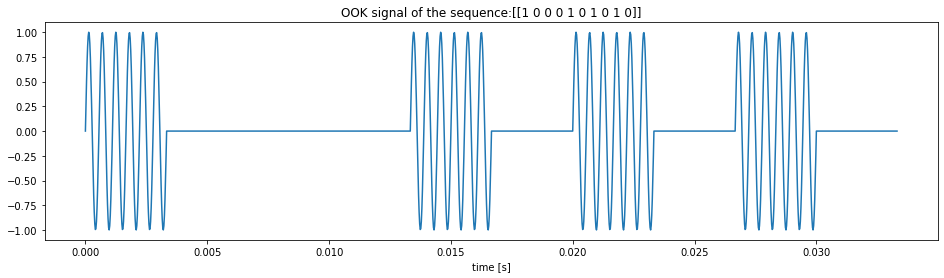

In [26]:
np.random.seed(seed=1)
bits = randn(Nbits, 1) > 0
M = np.tile(bits, (1, Ns))
t = r_[0.0:N] / fs
OOK = M.ravel() * sin(2 * pi * f0 * t)

fig = figure(figsize = (16, 4))
plot(t, OOK)
xlabel('time [s]')
title('OOK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

(0.0, 4096.0, 0.0, 294.0)

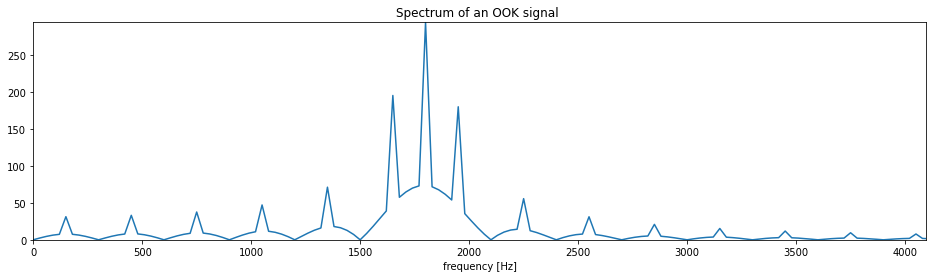

In [33]:
f = r_[0:N/2.0]/N*fs

OOK_f = (np.fft.fft(OOK))
fig = figure(figsize = (16,4))
plot(f, abs(OOK_f[:int(len(OOK_f)/2)]))
xlabel('frequency [Hz]')
title('Spectrum of an OOK signal ')
axis((0,4096,0,max(abs(OOK_f))))